In [14]:
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift
from gathering.csr_kick import calc_csr_kick
import time

c_light = scipy.constants.c
e_charge = scipy.constants.e

# Parameters

In [189]:
gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34  # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Q = e_charge * 6.25e9


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
P0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = 1e9* 2.8179403227E-15 * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

# Beam definition

In [190]:
# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread

In [191]:
# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

In [50]:
len(beam[0])

1000000

In [51]:
np.mean(np.abs(beam[5]))

3.989416315395298e-05

In [52]:
# Check beam optics
P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
P.twiss()

{'alpha_x': 0.07140731799734733,
 'beta_x': 5.231423558032416,
 'gamma_x': 0.19212724680270407,
 'emit_x': 1.0187762035464371e-10,
 'eta_x': 0.012093798967067172,
 'etap_x': -0.04838054983616345,
 'norm_emit_x': 9.988082420656697e-07}

In [64]:
# Save the initial beam to run in Bmad
P.write_bmad('Glen_beam_Np1M.txt',p0c = P0c, t_ref = 0)

# Main Loop

In [192]:
# Main switch
CSRon = False

In [193]:
# save the initial status

Plist = []       # To save the beam at each step
all_output = []  # To save the wake and grid at each step
slist = [0]      # To save the s position at each step
s = 0

P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
Plist.append(P)


ds = 0.01

for i in range(50):
    print("Running", i+1 , "th loop...") 

    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)

    
    ## Calculate CSR kicks to xp and delta
    ####===================================
    
    if (CSRon):
    
        sigma_x = np.std(beam[0])
        sigma_z = np.std(beam[4])
  
        output = calc_csr_kick(beam, charges, Np, 10000, rho, Nz=500, sigma_z=sigma_z, Nx=500, sigma_x=sigma_x, verbose=True)
        all_output.append(output)

        delta_kick = output['delta_kick'] 
        print('Typical delta:', np.mean(np.abs(beam[5])))
        print('Applied typical kick:', np.mean(np.abs(delta_kick)))    
        beam[5] = beam[5] + delta_kick * ds
    
        #xp_kick = output['xp_kick'] 
        #beam[1] = beam[1] + xp_kick * ds
    
    ####====================================

    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)
    
    # save the beam
    P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
    Plist.append(P)
    
    # save the s
    s += ds
    slist.append(s)

Running 1 th loop...
Running 2 th loop...
Running 3 th loop...
Running 4 th loop...
Running 5 th loop...
Running 6 th loop...
Running 7 th loop...
Running 8 th loop...
Running 9 th loop...
Running 10 th loop...
Running 11 th loop...
Running 12 th loop...
Running 13 th loop...
Running 14 th loop...
Running 15 th loop...
Running 16 th loop...
Running 17 th loop...
Running 18 th loop...
Running 19 th loop...
Running 20 th loop...
Running 21 th loop...
Running 22 th loop...
Running 23 th loop...
Running 24 th loop...
Running 25 th loop...
Running 26 th loop...
Running 27 th loop...
Running 28 th loop...
Running 29 th loop...
Running 30 th loop...
Running 31 th loop...
Running 32 th loop...
Running 33 th loop...
Running 34 th loop...
Running 35 th loop...
Running 36 th loop...
Running 37 th loop...
Running 38 th loop...
Running 39 th loop...
Running 40 th loop...
Running 41 th loop...
Running 42 th loop...
Running 43 th loop...
Running 44 th loop...
Running 45 th loop...
Running 46 th loop.

In [194]:
pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in Plist]

In [195]:
beta_x_list = [P.twiss()['beta_x'] for P in Plist]
alpha_x_list = [P.twiss()['alpha_x'] for P in Plist]
eta_x_list = [P.twiss()['eta_x'] for P in Plist]
beamsize_x_list = [P['sigma_x'] for P in Plist]

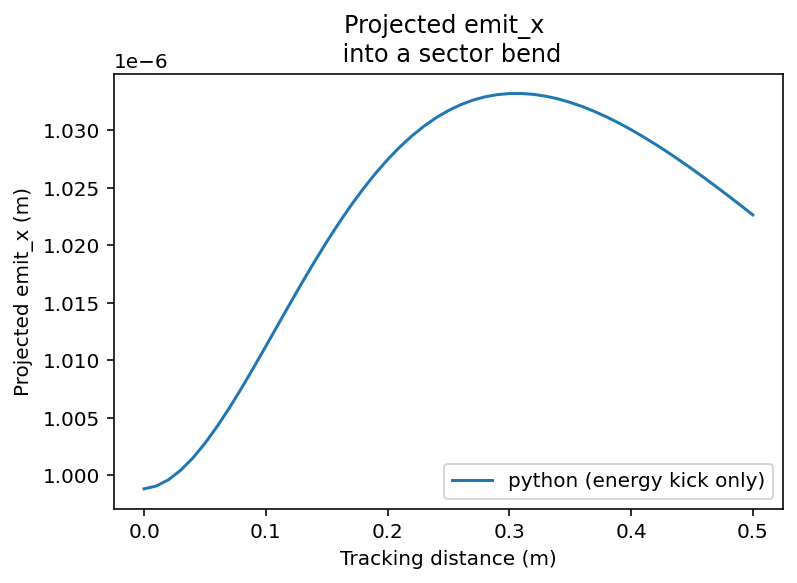

In [54]:
plt.plot(slist, pro_emit_x_list, label = 'python (energy kick only)');

plt.xlabel('Tracking distance (m)')
plt.ylabel('Projected emit_x (m)')
plt.title('Projected emit_x \n into a sector bend')
plt.legend()

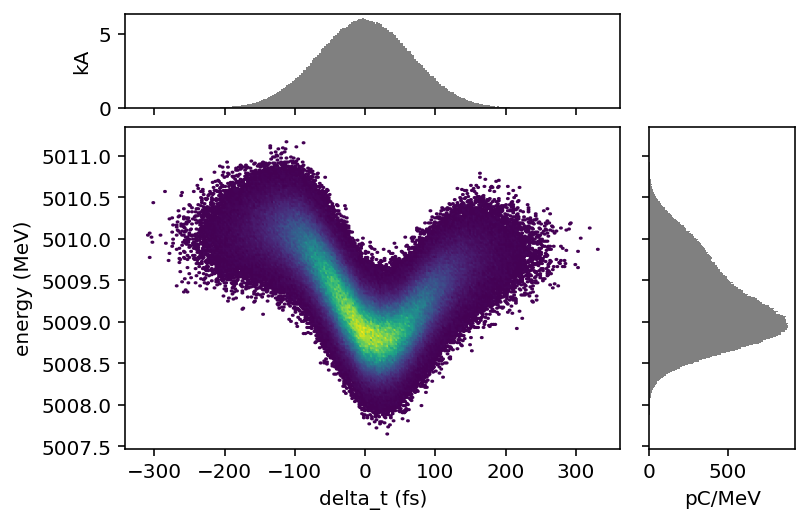

In [55]:
Plist[-1].plot('delta_t', 'energy', bins=250)

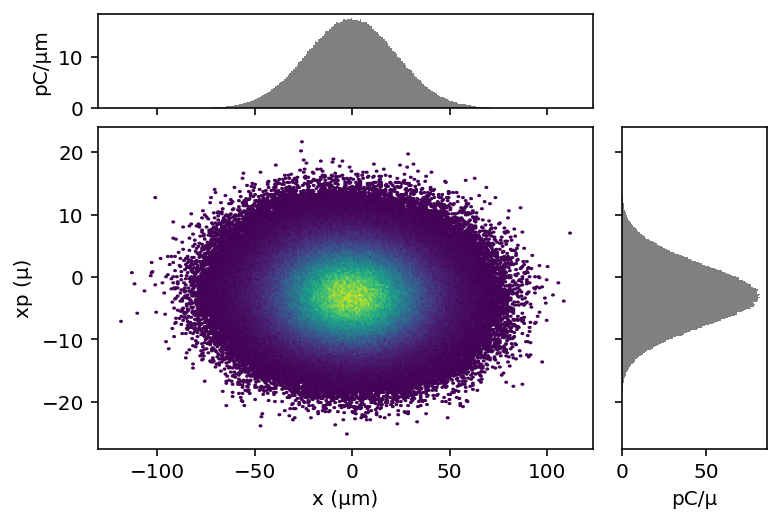

In [56]:
Plist[-1].plot('x', 'xp', bins=250)

## Import Tao results 

In [57]:
from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File
filename = '/global/cfs/cdirs/m669/wlou1991/bmad_distributions/bmad_svn/tao/examples/simple_bend_Glen/beam_dump.h5'
with File(filename, 'r') as h5:
    ppaths = particle_paths(h5)
    PG = [ParticleGroup(h5[g]) for g in ppaths]
    
def get_stat(key):
    return [P[key] for P in PG]

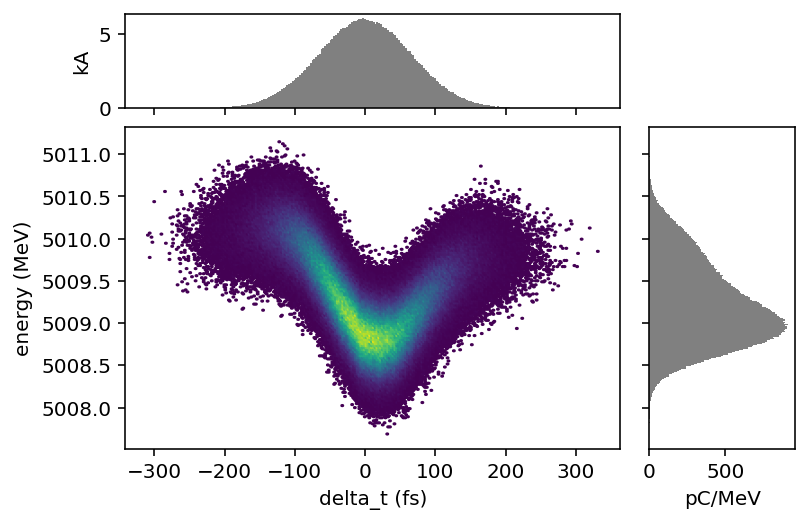

In [71]:
PG[-1].plot('delta_t', 'energy', bins=250)

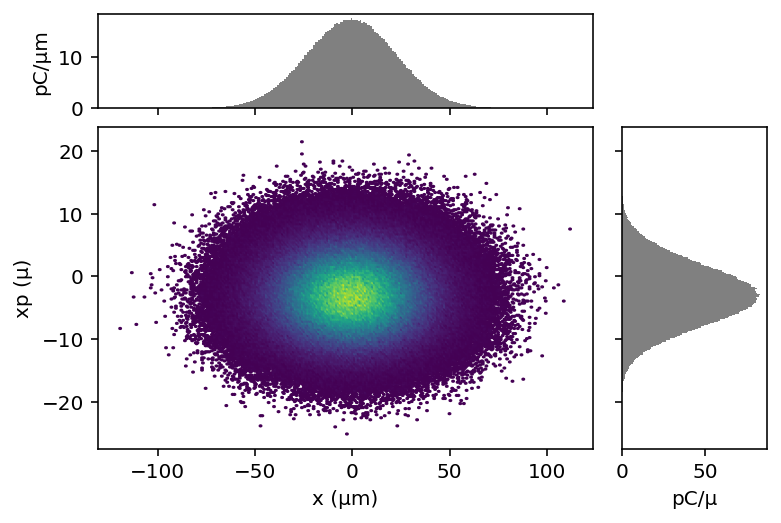

In [83]:
PG[-1].plot('x', 'xp', bins=250)

In [58]:
tao_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PG]

In [135]:
tao_beta_x_list = [P.twiss()['beta_x'] for P in PG]
tao_alpha_x_list = [P.twiss()['alpha_x'] for P in PG]
tao_eta_x_list = [P.twiss()['eta_x'] for P in PG]
tao_beamsize_x_list = [P['sigma_x'] for P in PG]

In [62]:
haha = (pro_emit_x_list - pro_emit_x_list[0])/pro_emit_x_list * 100
lala = (tao_pro_emit_x_list - tao_pro_emit_x_list[0])/tao_pro_emit_x_list * 100

haha = pro_emit_x_list 
lala = tao_pro_emit_x_list 

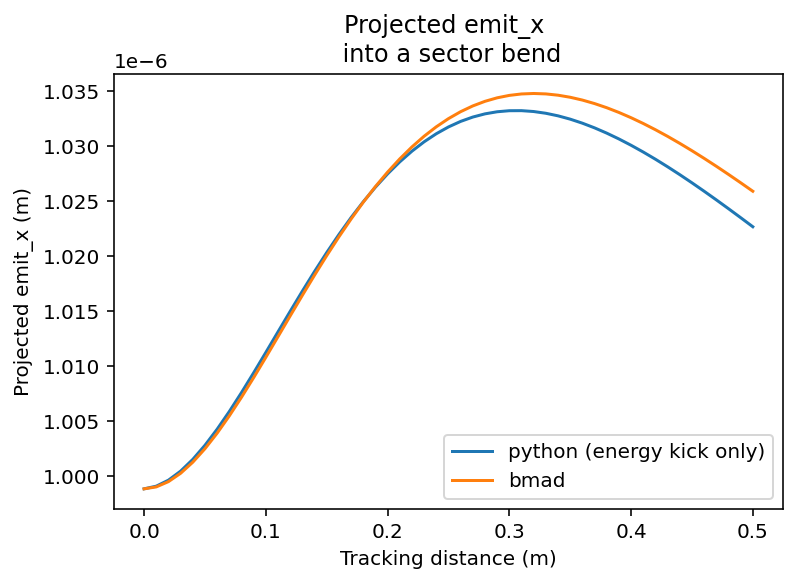

In [63]:
plt.plot(slist, haha, label = 'python (energy kick only)')
plt.plot(slist, lala, label = 'bmad')

plt.xlabel('Tracking distance (m)')
plt.ylabel('Projected emit_x (m)')
plt.title('Projected emit_x \n into a sector bend')
plt.legend()

## Import Elegant results

In [16]:
from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup
#, particle_paths
#from h5py import File

In [80]:
locationList = ['M0',\
                'M1','M2','M3','M4','M5','M6','M7','M8','M9','M10',\
               'M11','M12','M13','M14','M15','M16','M17','M18','M19','M20',\
               'M21','M22','M23','M24','M25','M26','M27','M28','M29','M30',\
               'M31','M32','M33','M34','M35','M36','M37','M38','M39','M40',\
               'M41','M42','M43','M44','M45','M46','M47','M48','M49','M50']

In [81]:
def elegant_beam(location):
    beam_dir = '/global/homes/w/wlou1991/CSR2D/elegant/results_Np1M_Nb1000/'
    OUTFILE= beam_dir + locationList[location-1]+'.out'
    print('Filename: ' + OUTFILE)
    DAT = elegant_to_data(OUTFILE, charge = 1.0013603962588557E-09)
    P1 = ParticleGroup(data=DAT)
    Palive = P1.where(P1['status'] == 1)
    return Palive

In [96]:
# This can be slow...
#PE = [elegant_beam(i) for i in range(1,51)]

In [86]:
eleg_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PE]

In [134]:
eleg_beta_x_list = [P.twiss()['beta_x'] for P in PE]
eleg_alpha_x_list = [P.twiss()['alpha_x'] for P in PE]
eleg_eta_x_list = [P.twiss()['eta_x'] for P in PE]
eleg_beamsize_x_list = [P['sigma_x'] for P in PE]

# Plotting

In [159]:
font = {'weight' : 'medium',
        'size'   : 12}

matplotlib.rc('font', **font)

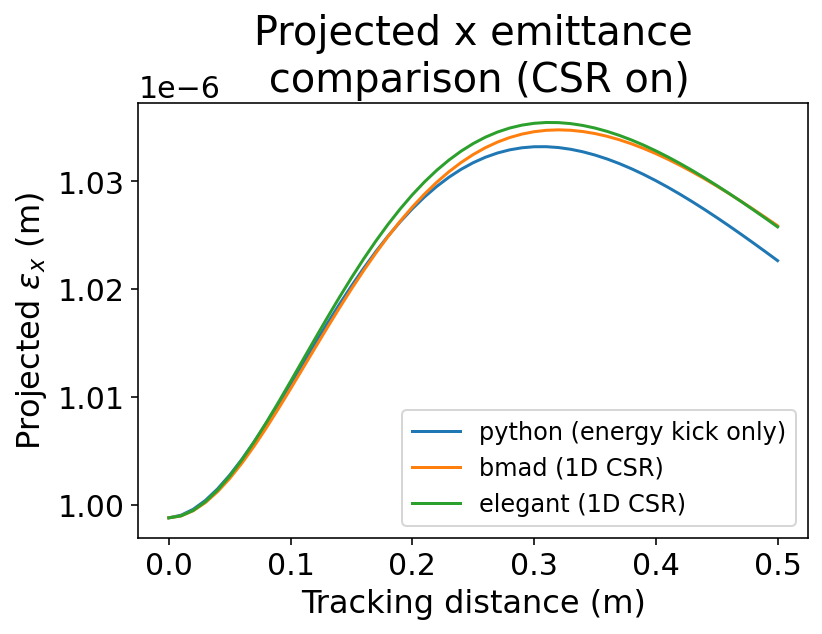

In [180]:
plt.plot(slist, pro_emit_x_list, label = 'python (energy kick only)')
plt.plot(slist, tao_pro_emit_x_list, label = 'bmad (1D CSR)')
plt.plot(slist, eleg_pro_emit_x_list, label = 'elegant (1D CSR)')

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\epsilon_x$ (m)', fontsize=16)
plt.title('Projected x emittance\n comparison (CSR on)',  fontsize=20)
plt.legend()

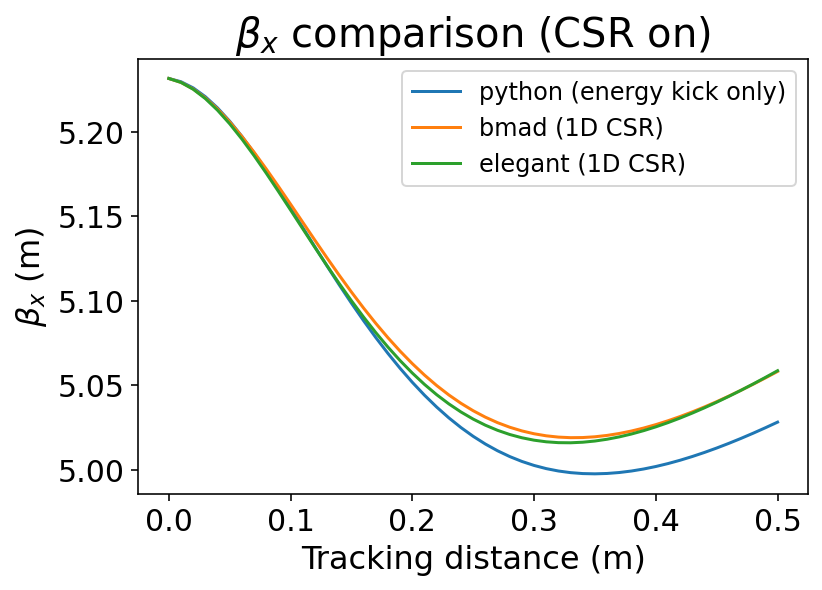

In [182]:
plt.plot(slist, beta_x_list, label = 'python (energy kick only)')
plt.plot(slist, tao_beta_x_list, label = 'bmad (1D CSR)')
plt.plot(slist, eleg_beta_x_list, label = 'elegant (1D CSR)')

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\beta_x$ (m)', fontsize=16)
plt.title(r'$\beta_x$ comparison (CSR on)', fontsize=20)
plt.legend()

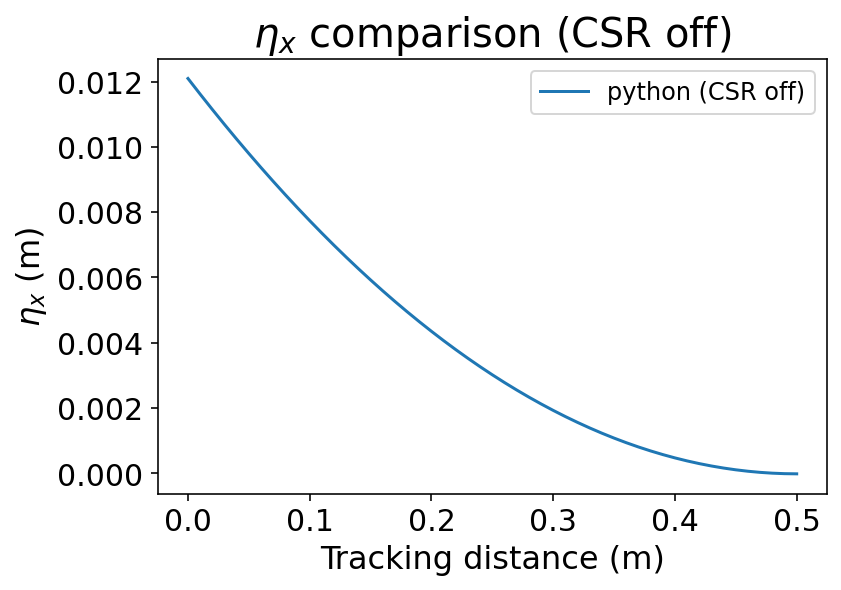

In [197]:
plt.plot(slist, eta_x_list, label = 'python (CSR off)')
#plt.plot(slist, tao_eta_x_list, label = 'bmad (1D CSR)')
#plt.plot(slist, eleg_eta_x_list, label = 'elegant (1D CSR)')

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\eta_x$ (m)', fontsize=16)
plt.title(r'$\eta_x$ comparison (CSR off)', fontsize=20)
plt.legend()

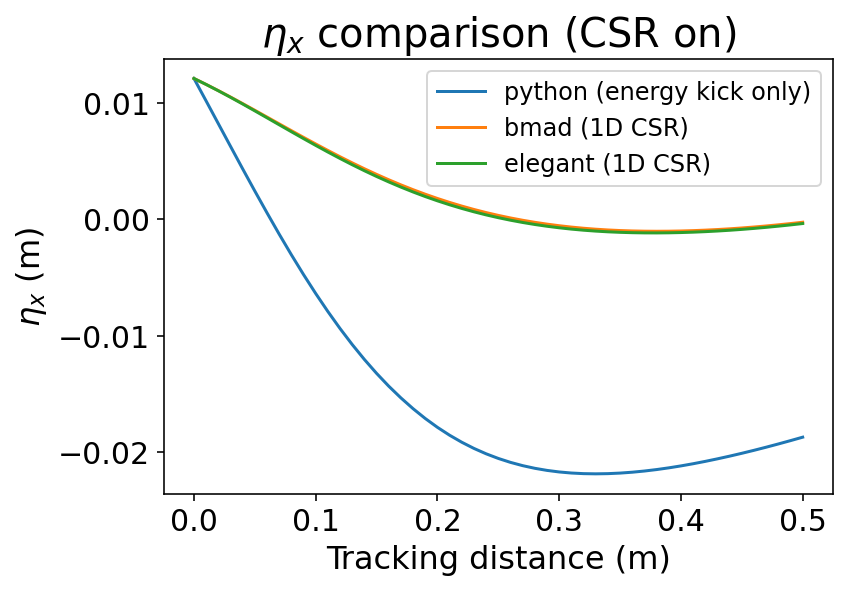

In [183]:
plt.plot(slist, eta_x_list, label = 'python (energy kick only)')
plt.plot(slist, tao_eta_x_list, label = 'bmad (1D CSR)')
plt.plot(slist, eleg_eta_x_list, label = 'elegant (1D CSR)')

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\eta_x$ (m)', fontsize=16)
plt.title(r'$\eta_x$ comparison (CSR on)', fontsize=20)
plt.legend()

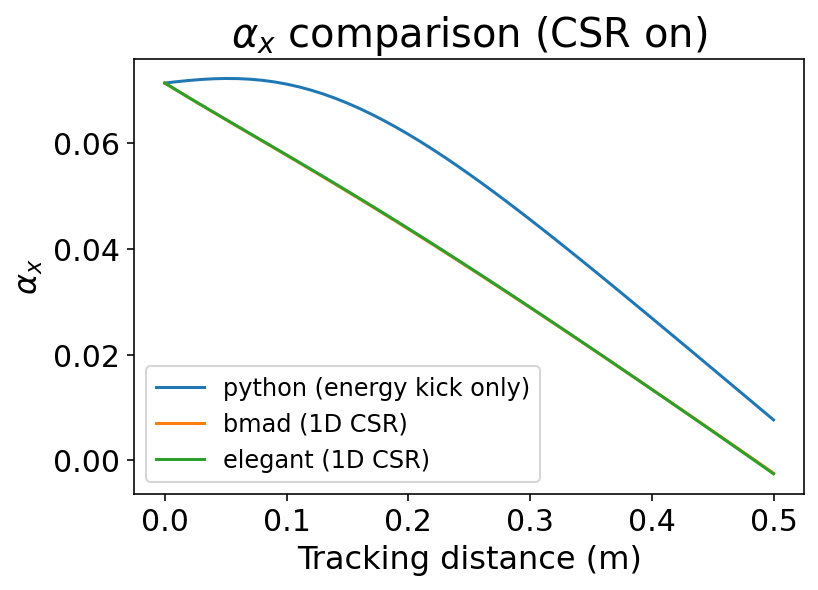

In [188]:
plt.plot(slist, alpha_x_list, label = 'python (energy kick only)')
plt.plot(slist, tao_alpha_x_list, label = 'bmad (1D CSR)')
plt.plot(slist, eleg_alpha_x_list, label = 'elegant (1D CSR)')

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\alpha_x$', fontsize=16)
plt.title(r'$\alpha_x$ comparison (CSR on)', fontsize=20)
plt.legend()

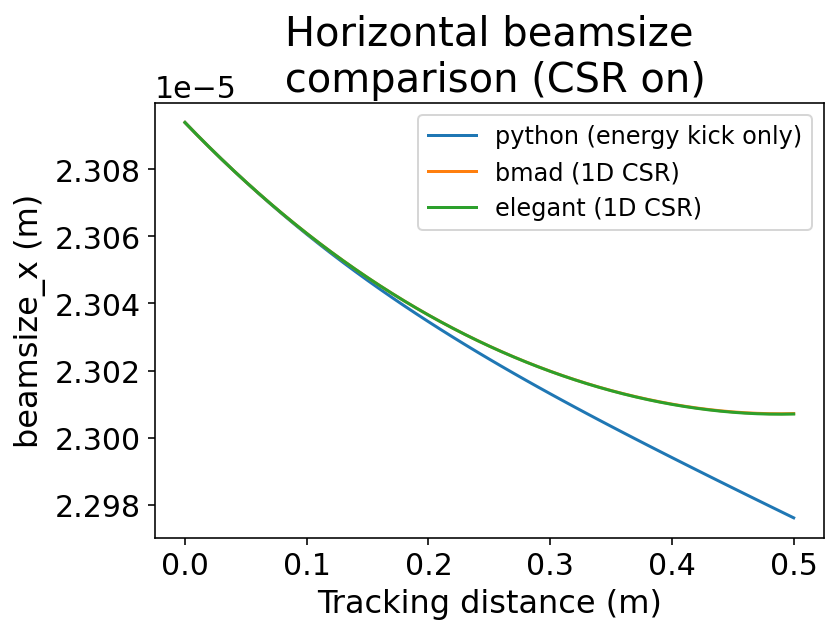

In [187]:
plt.plot(slist, beamsize_x_list, label = 'python (energy kick only)')
plt.plot(slist, tao_beamsize_x_list, label = 'bmad (1D CSR)')
plt.plot(slist, eleg_beamsize_x_list, label = 'elegant (1D CSR)')

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('beamsize_x (m)', fontsize=16)
plt.title('Horizontal beamsize\n comparison (CSR on)', fontsize=20)
plt.legend()

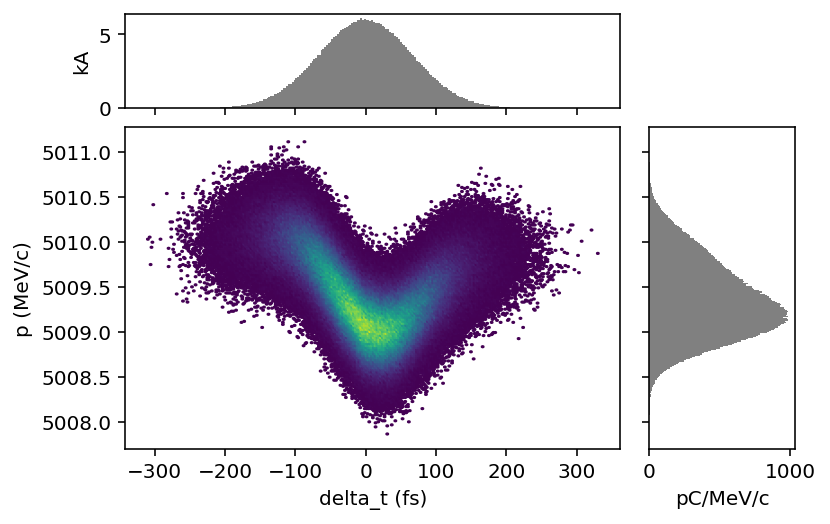

In [110]:
Plist[40].plot('delta_t', 'p', bins=250)

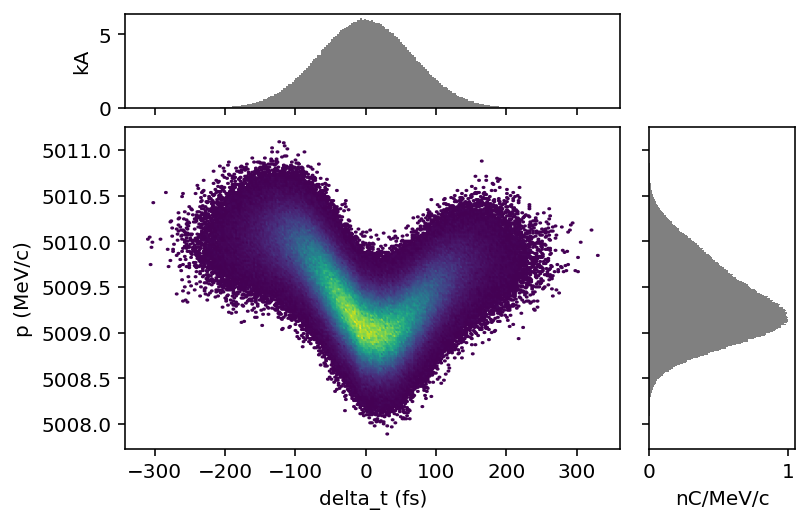

In [111]:
PG[40].plot('delta_t', 'p', bins=250)

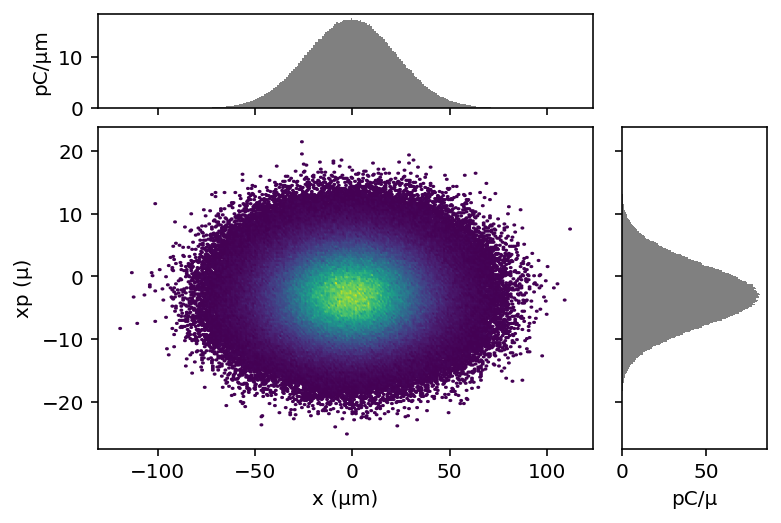

In [117]:
PE[50].plot('x', 'xp', bins=250)

## Save files

In [150]:
np.savetxt('slist.txt', slist)

In [147]:
np.savetxt('pro_emit_x_list.txt', pro_emit_x_list)
np.savetxt('beta_x_list.txt', beta_x_list)
np.savetxt('alpha_x_list.txt', alpha_x_list)
np.savetxt('eta_x_list.txt', eta_x_list)
np.savetxt('beamsize_x_list.txt', beamsize_x_list)

In [148]:
np.savetxt('tao_pro_emit_x_list.txt', tao_pro_emit_x_list)
np.savetxt('tao_beta_x_list.txt', tao_beta_x_list)
np.savetxt('tao_alpha_x_list.txt', tao_alpha_x_list)
np.savetxt('tao_eta_x_list.txt', tao_eta_x_list)
np.savetxt('tao_beamsize_x_list.txt', tao_beamsize_x_list)

In [149]:
np.savetxt('eleg_pro_emit_x_list.txt', eleg_pro_emit_x_list)
np.savetxt('eleg_beta_x_list.txt', eleg_beta_x_list)
np.savetxt('eleg_alpha_x_list.txt', eleg_alpha_x_list)
np.savetxt('eleg_eta_x_list.txt', eleg_eta_x_list)
np.savetxt('eleg_beamsize_x_list.txt', eleg_beamsize_x_list)

## Check emittance

In [4]:
def projected_emit_x(beam):
    SS = np.cov(beam)
    s00 = SS[0][0] - SS[0][5]*SS[0][5] / SS[5][5]
    s01 = SS[0][1] - SS[0][5]*SS[1][5] / SS[5][5]
    s11 = SS[1][1] - SS[1][5]*SS[1][5] / SS[5][5]

    return np.sqrt(s00*s11 - s01**2)

In [5]:
print(emit_x)          # desired
projected_emit_x(beam) # from the beam

1.0199918400652795e-10


1.0187762619965156e-10

### Additional parameters 

In [95]:
temp = np.array([all_output[i]['Ws_grid'] for i in range(len(all_output))])
np.save('Ws_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [96]:
temp = np.array([all_output[i]['Wx_grid'] for i in range(len(all_output))])
np.save( 'Wx_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [97]:
temp = np.array([all_output[i]['zvec'] for i in range(len(all_output))])
np.save( 'zvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [98]:
temp = np.array([all_output[i]['xvec'] for i in range(len(all_output))])
np.save( 'xvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [99]:
np.save( 'slist_0.5m_50steps.npy', slist, allow_pickle=True)